<a href="https://colab.research.google.com/github/AIM-Harvard/CXR-Lung-Risk/blob/main/notebooks/cxr_lung_risk_mwe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning to Estimate Lung-related Mortality from Chest Radiographs

Jakob Weiss⁺, Vineet K. Raghu⁺, Dennis Bontempi, David C. Christiani, Raymond H. Mak, Michael T. Lu⁺, Hugo Aerts⁺.

⁺ equal contribution

## **About this Article**

If you use code or parts of this code in your work, please cite our publication and/or the Zenodo supplement:

> Weiss, J., Raghu, V.K., Bontempi, D. et al. Deep learning to estimate lung disease mortality from chest radiographs. Nat Commun 14, 2797 (2023). https://doi.org/10.1038/s41467-023-37758-5

> Weiss, Jakob, Raghu, Vineet, Bontempi, Dennis, Christiani, David, Mak, Raymond, Lu, Michael T., & Aerts, Hugo. (2023). Deep learning to estimate lung disease mortality from chest radiographs. In Nature Communications (1.0.0). Zenodo. https://doi.org/10.5281/zenodo.7941660


The Nature Communications publication is open access and can be accessed [at this link](https://www.nature.com/articles/s41467-023-37758-5).

The supporting material, including the sample data and the pre-trained Deep Learning models used in this notebook, can be found at [Zenodo project page](https://zenodo.org/record/7941660#.ZGOiqOxBzdp).

---

## **Introduction**

Prevention and management of chronic lung diseases (COPD, lung cancer, etc.) are of great importance. While dedicated tests are available for reliable diagnosis and monitoring, accurate identification of those who will eventually develop severe morbidity and mortality is currently limited. Therefore, new possibilities to improve risk stratification are desirable. Chest radiographs (CXR) are common in patients at risk for chronic lung disease and may provide a window into long-term risk. Here, we developed a deep learning model (CXR Lung-Risk) to predict the risk of lung disease mortality from a single routine CXR image.

The CXR Lung-Risk model was developed using 147,497 CXRs of 40,643 asymptomatic participants from the Prostate, Lung, Colorectal, and Ovarian (PLCO) cancer screening trial to predict lung-related mortality (COPD, interstitial lung disease, emphysema, lung cancer) based on a single CXR image as input. In three independent testing datasets comprising 15,976 individuals, we found that CXR Lung-Risk showed a graded association with lung disease mortality which remained robust after adjustment for known risk factors, including chronological age, smoking, and radiologic findings (adjusted hazard ratio for highest risk group vs. reference up to 12.15 [8.85-16.68]; p < 0.001). Adding CXR Lung-Risk to a multivariable model improved estimates of lung disease mortality (for all p ≤ 0.004).

These findings motivate the use of deep learning algorithms to translate a patient’s visual appearance on easily obtainable and low-cost chest radiograph images into objective, quantitative, and clinically useful measures. Our results demonstrate that such approaches can improve prognostication in individuals with lung diseases. This allows for improved risk assessment of those who would benefit most from personalized prevention and treatment strategies. 

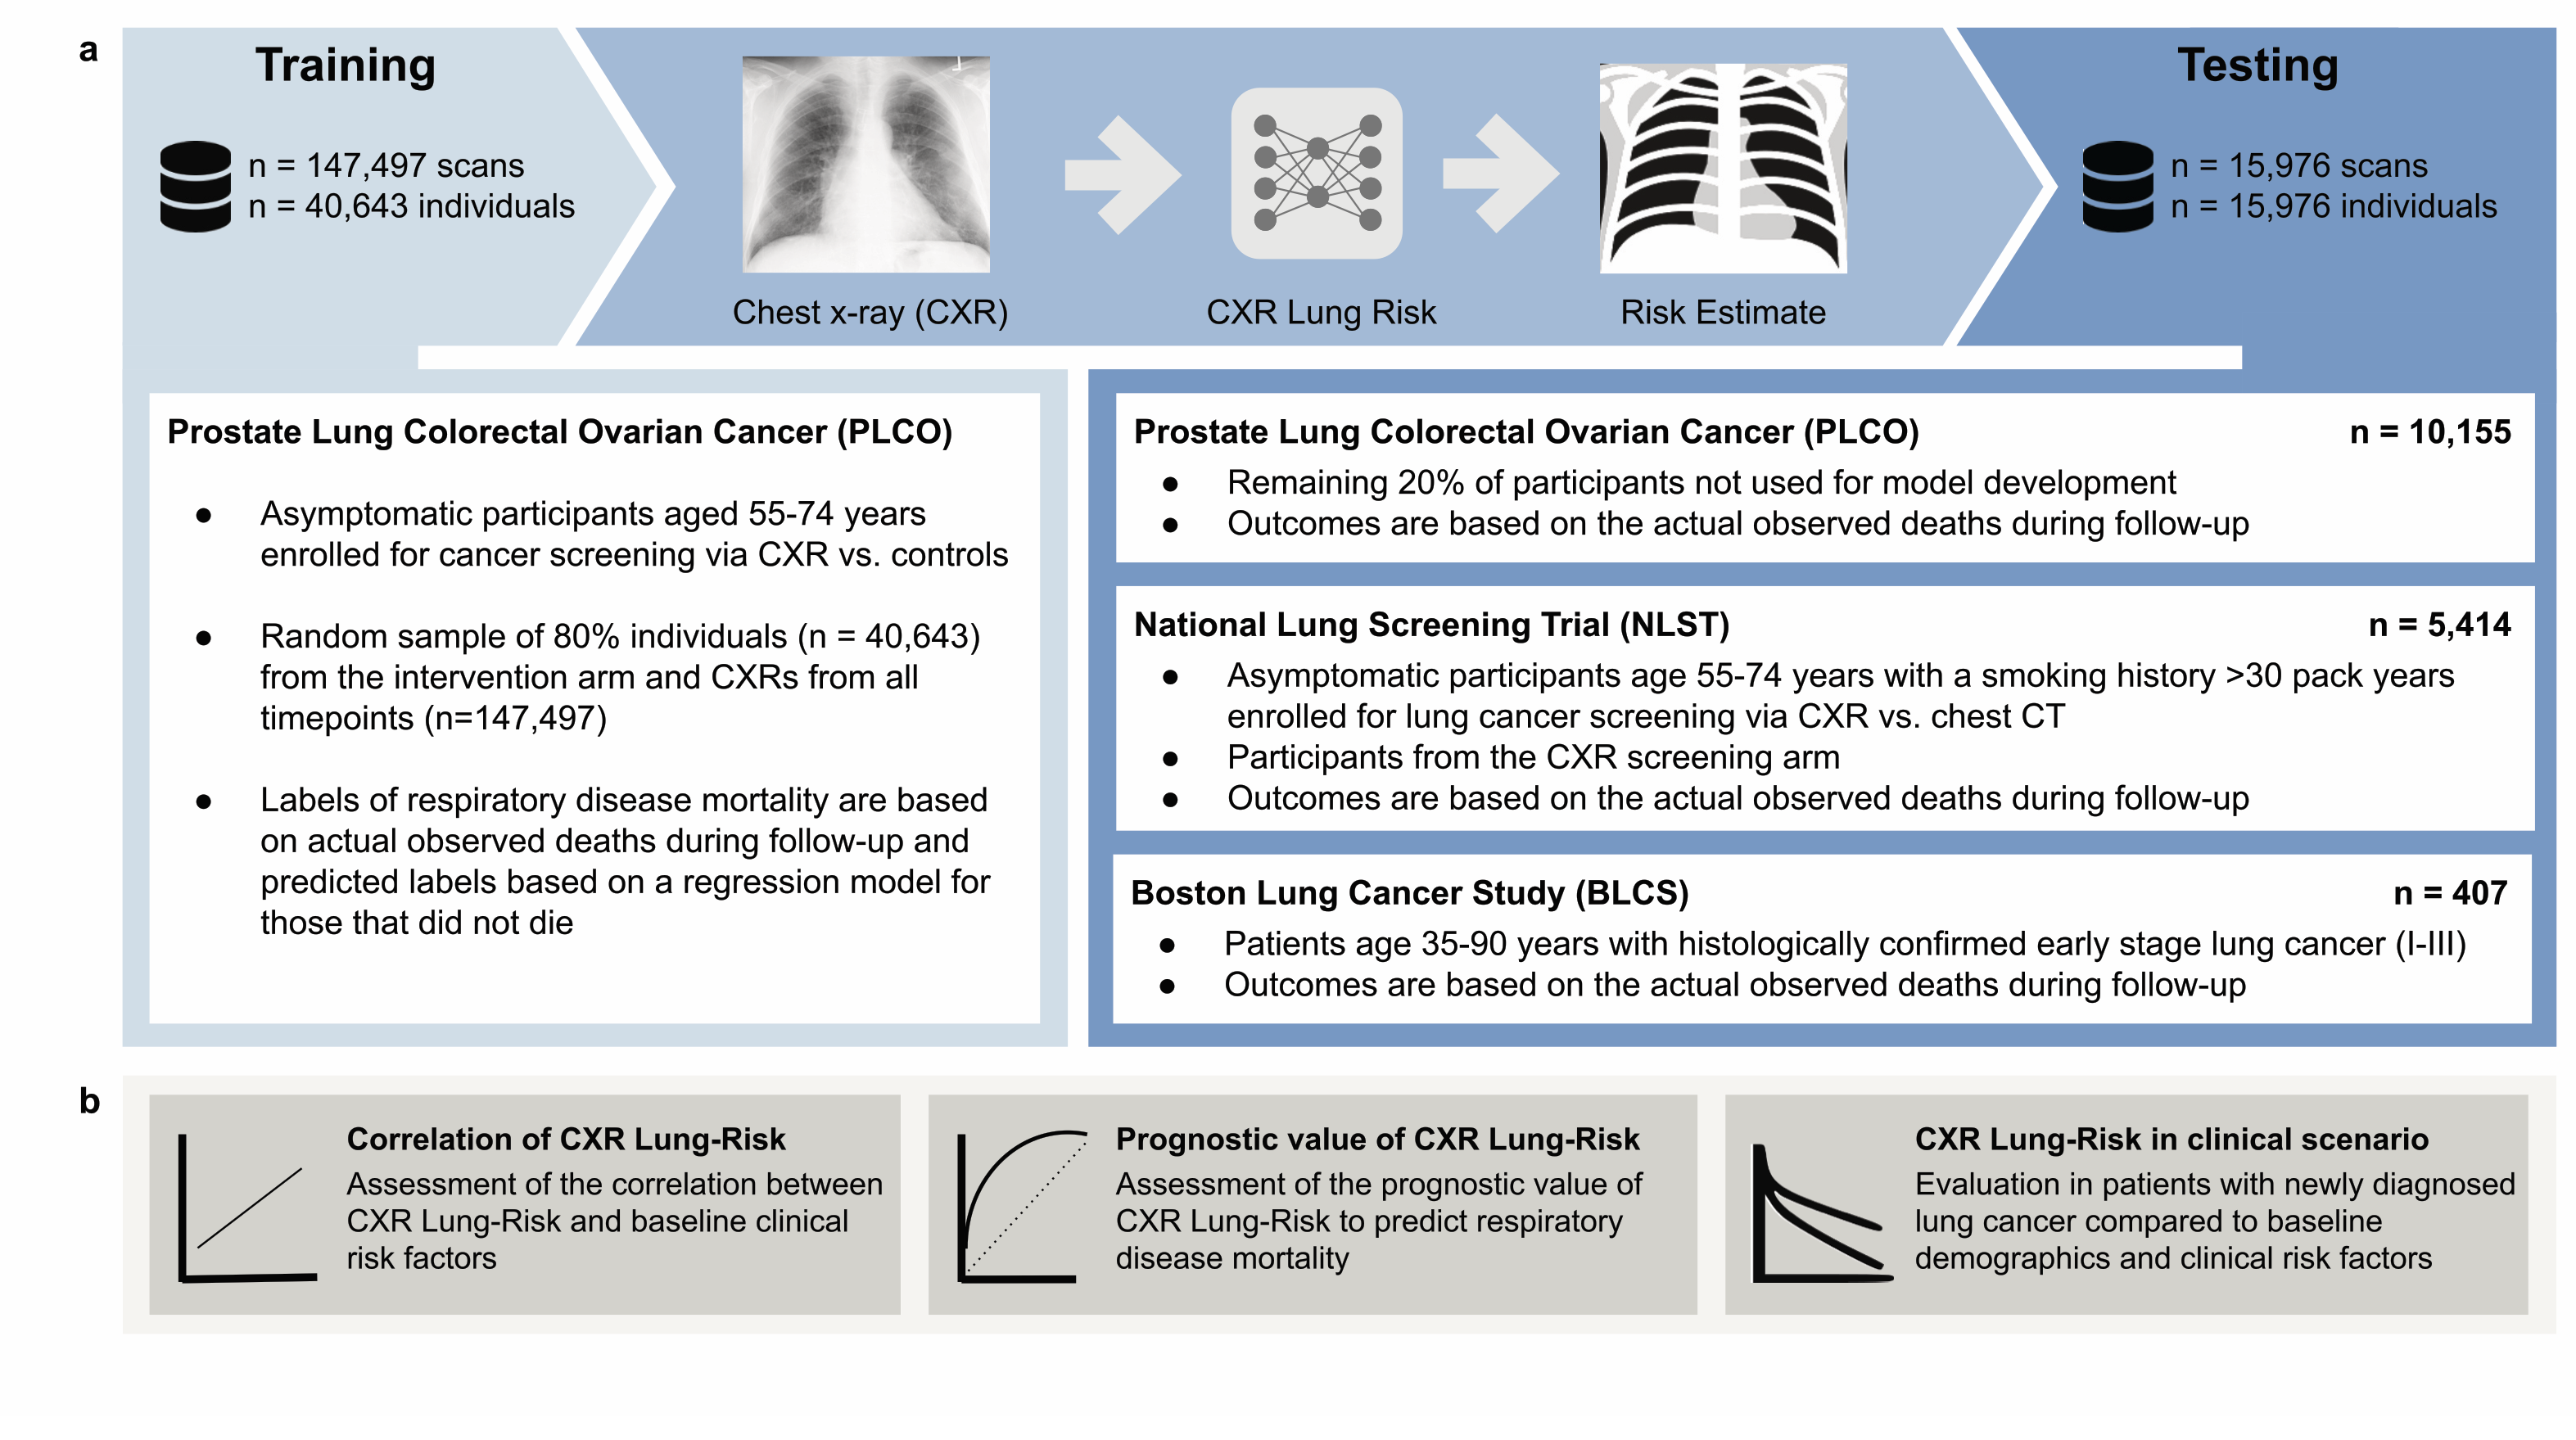

---

## **Environment Setup**

Install `dcmtk` for DICOM to TIF conversion, and `ImageMagick` for TIF to PNG conversion.

We will use both of the packages to convert DICOM CXR data to images that are ready to be processed by the CXR-Lung-Risk pipeline.

In [1]:
%%capture
!sudo apt install imagemagick dcmtk

In [2]:
# check wether the Colab Instance was correctly changed to a GPU instance
gpu_list = !nvidia-smi --list-gpus

use_gpu = False if "failed" in gpu_list[0] else True

In [3]:
if use_gpu:
  print("The notebook instance is equipped with a GPU.")
else:
  print("The notebook instance is NOT equipped with a GPU. Processing times will be slower.")

The notebook instance is equipped with a GPU.


---
Before getting to the processing tutorial, we must download the archive storing the trained weights on the Colab Instance from the Zenodo project's page.

The archive size is roughly 2 GBs, and the download should take from one to five/ten minutes, depending on the Colab instance network and other factors. If for some reason the download process appears to be too slow or stuck, feel free to stop and re-run the following cell.

Alternatively, if the download appears very slow, you can download the trained weights from Zenodo via your browser and upload them on the Colab instance.

In [4]:
weights_url = "https://zenodo.org/record/7941660/files/ensamble-model-weights.zip"
path_to_models_archive = "ensemble-model-weights.zip"

!wget $weights_url -O $path_to_models_archive

--2023-05-16 17:50:27--  https://zenodo.org/record/7941660/files/ensamble-model-weights.zip
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2159460140 (2.0G) [application/octet-stream]
Saving to: ‘ensemble-model-weights.zip’

ensemble-model-weig 100%[===================>]   2.01G  6.94MB/s    in 5m 36s  

2023-05-16 17:56:05 (6.13 MB/s) - ‘ensemble-model-weights.zip’ saved [2159460140/2159460140]



---

Next, we are going to download the pre-trained Torch version of the InceptionV4 architecture from [`pretrainedmodels`](https://github.com/Cadene/pretrained-models.pytorch). The information stored in the file will be needed for the inference phase.

The file size is roughly 160 MBs, and the download should take from one to five/ten minutes, depending on the Colab instance network and other factors. If for some reason the download process appears to be too slow or stuck, feel free to stop and re-run the following cell.

In [5]:
!mkdir -p /root/.cache/torch/hub/checkpoints/

path_to_checkpoint_archive = "inceptionv4-8e4777a0.pth.zip"

weights_url = "https://zenodo.org/record/7941660/files/inceptionv4-8e4777a0.pth.zip"
!wget $weights_url -O $path_to_checkpoint_archive

--2023-05-16 17:56:05--  https://zenodo.org/record/7941660/files/inceptionv4-8e4777a0.pth.zip
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 158828238 (151M) [application/octet-stream]
Saving to: ‘inceptionv4-8e4777a0.pth.zip’

inceptionv4-8e4777a 100%[===================>] 151.47M  8.39MB/s    in 26s     

2023-05-16 17:56:33 (5.73 MB/s) - ‘inceptionv4-8e4777a0.pth.zip’ saved [158828238/158828238]



In [6]:
%%capture
!unzip $path_to_checkpoint_archive

!mv "/content/inceptionv4-8e4777a0.pth" "/root/.cache/torch/hub/checkpoints/inceptionv4-8e4777a0.pth"
!rm $path_to_checkpoint_archive

---

We can now clone the project's github repository.

The repository contains all the code and information needed to run the pipeline, as well as a few image samples from the PLCO trial dataset we have the permission to share. 

The complete datasets used for model development and testing are available from the National Cancer Institute (NCI - at the National Institute of Health, NIH) ([PLCO](https://biometry.nci.nih.gov/cdas/plco/)) and the American College of Radiology Imaging Network (ACRIN) ([NLST](https://biometry.nci.nih.gov/cdas/nlst/)).



In [7]:
repo_url = "https://github.com/AIM-Harvard/CXR-Lung-Risk"
path_to_repo_folder = "cxr-lung-risk"

!git clone $repo_url $path_to_repo_folder

Cloning into 'cxr-lung-risk'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 52 (delta 8), reused 44 (delta 4), pack-reused 0
Unpacking objects: 100% (52/52), 3.43 MiB | 7.31 MiB/s, done.


In [8]:
%%capture
import os
import numpy as np
import pandas as pd

from google.colab import files

# unzip the models archive
path_to_models_folder = "models"
if not os.path.exists(path_to_models_folder):
  os.mkdir(path_to_models_folder)

!unzip $path_to_models_archive
!mv /content/ensamble-model-weights/*.pth /content/models

# make `path_to_repo_folder` the default working directory
%cd $path_to_repo_folder

Last but not least, we need to set some of the parameters and paths the processing pipelines need to run as intended.

In [9]:
# the number of actual threads spawned will depend on the number of cores
# the Colab instance is equipped with!
num_workers = 16

# default location for the "models" folder
mdl_dir = "../models/ensamble-model-weights"

test_set_dir = "dummy_datasets/test_images"

model_details_fn = "src/CXR_Lung_Risk_Specs.csv"
model_details_df = pd.read_csv(model_details_fn)

# default base name for the weight files of the models in the ensemble
mdl_name = "Lung_Age_081221"

# default location of the output file (path_to_repo_folder)
out_base_path = "output"
out_fn = "output.csv"
out_file_path = os.path.join(out_base_path, out_fn)

ensemble_weights_fn = "src/ensemble_weights.csv"
ensemble_weights_df = pd.read_csv(ensemble_weights_fn)

# -------------------------

print("Default location to be parsed for images to process:", test_set_dir)
print("Location to be parsed for models weights:", mdl_dir)
print("Model base name:", mdl_name)

Default location to be parsed for images to process: dummy_datasets/test_images
Location to be parsed for models weights: ../models/ensamble-model-weights
Model base name: Lung_Age_081221


---

## **Data Preparation**

To showcase how the conversion from DICOM to PNG (a necessary step for the pipeline to function as intended) works - and to encourage the community in using our model - we provide a small sample from Kaggle's [UNIFESP X-ray Body Part Classifier Competition dataset](https://www.kaggle.com/competitions/unifesp-x-ray-body-part-classifier).

When the user is interested in testing the CXR-Lung-Risk pipeline on another set of data, the only thing that they will have to change is the following cells - dealing with the paths to the dataset to pre-process.

The upload of the DICOM files (or a .zip file containing the DICOM files) can be done directly using the Google Colab GUI file explorer (on the left). They can then adapt the code in the following cells to match the name of the folder or of the archive to the one they uploaded.



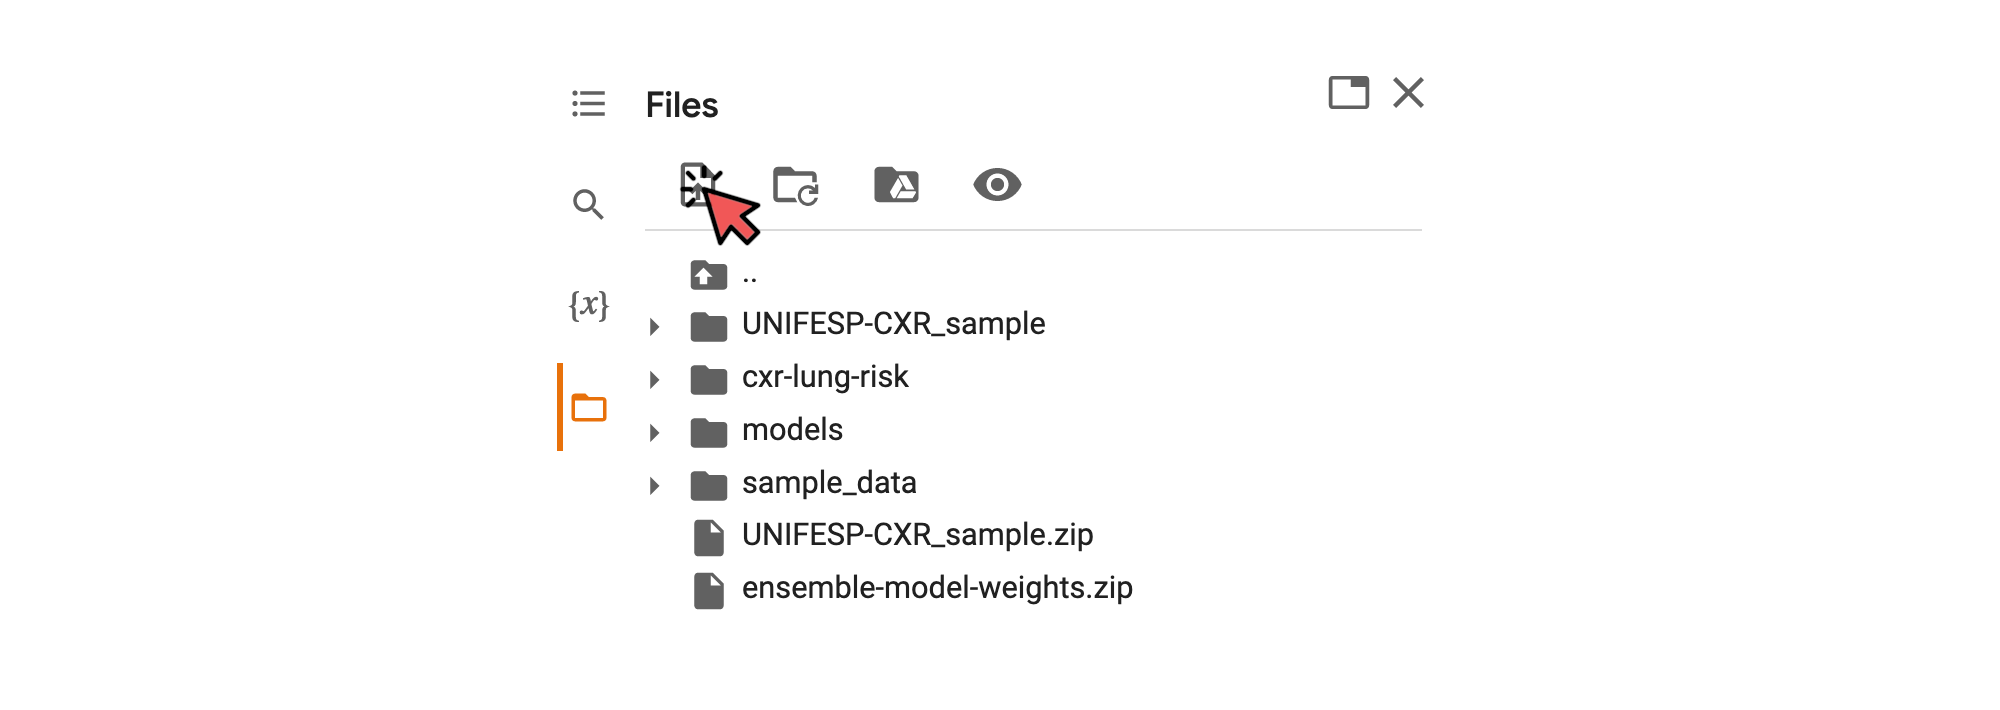

In [10]:
# pull a sample from the UNIFESP to showcase the pre-processing pipeline
# this step can be skipped when the user wants to test the pipeline on a user-provided dataset.
dicom_cxr_url = "https://zenodo.org/record/7941660/files/UNIFESP-CXR_sample.zip"

path_to_dicom_cxr_archive = "/content/UNIFESP-CXR_sample.zip"

!wget -O $path_to_dicom_cxr_archive $dicom_cxr_url

--2023-05-16 17:57:01--  https://zenodo.org/record/7941660/files/UNIFESP-CXR_sample.zip
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 573144 (560K) [application/octet-stream]
Saving to: ‘/content/UNIFESP-CXR_sample.zip’

/content/UNIFESP-CX 100%[===================>] 559.71K  1.33MB/s    in 0.4s    

2023-05-16 17:57:03 (1.33 MB/s) - ‘/content/UNIFESP-CXR_sample.zip’ saved [573144/573144]



Before moving on, the user will need to specify where the user-uploaded archive will be stored in the Colab Instance. If unsure, the user can get the path to the archive or the folder by simply selecting "copy path" from the dialog box that pops up when right-clicking on one of the files in the Google Colab GUI file explorer - and then set the `path_to_data_folder` variable accordingly.

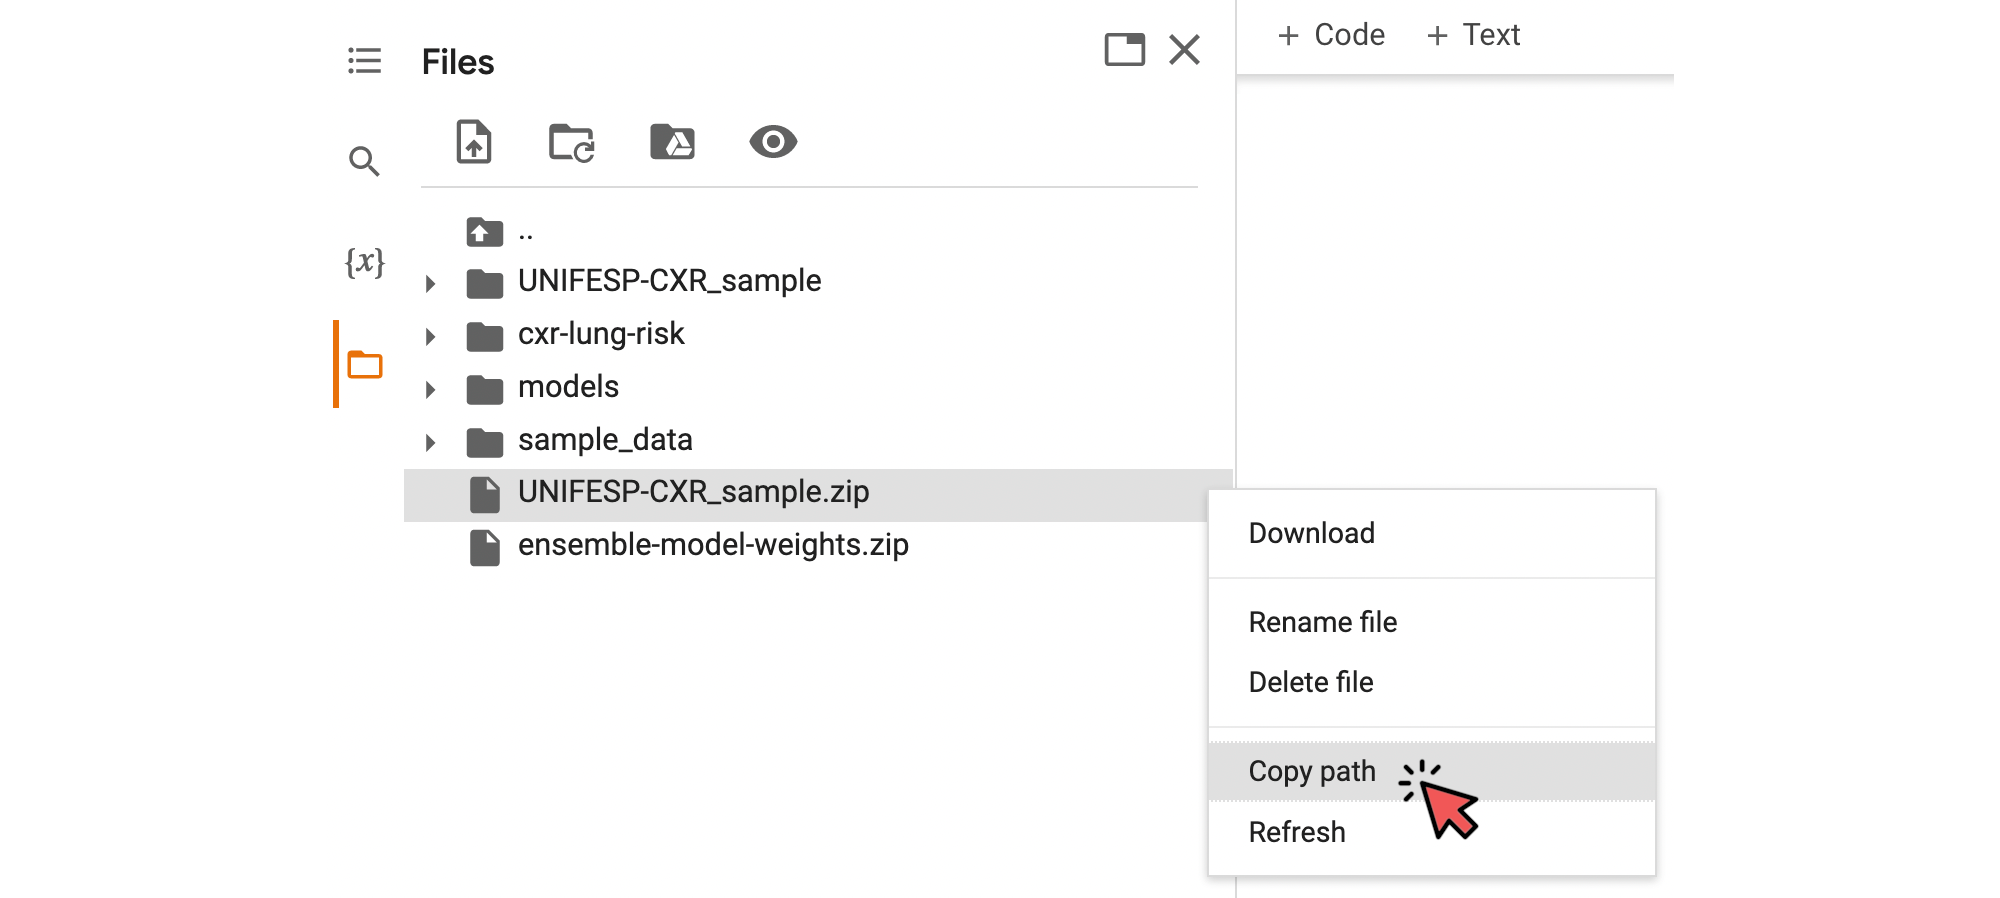

In [11]:
# path to the archive file
path_to_dicom_cxr_archive = "/content/UNIFESP-CXR_sample.zip"

# path to the folder where the content of the archive will be stored
path_to_data_folder = "/content/UNIFESP-CXR_sample"

# using "-j" we make sure the archive structure gets ignored
# (so that the following cells will work as intended)
!unzip -j $path_to_dicom_cxr_archive -d $path_to_data_folder

Archive:  /content/UNIFESP-CXR_sample.zip
  inflating: /content/UNIFESP-CXR_sample/1.2.826.0.1.3680043.8.498.12414243101975237693704262413365291546-c.dcm  
  inflating: /content/UNIFESP-CXR_sample/1.2.826.0.1.3680043.8.498.12764119488911678486346710898310965684-c.dcm  
  inflating: /content/UNIFESP-CXR_sample/1.2.826.0.1.3680043.8.498.23886477039785083148480341399342435216-c.dcm  
  inflating: /content/UNIFESP-CXR_sample/1.2.826.0.1.3680043.8.498.29960944389705651248668522443366935719-c.dcm  
  inflating: /content/UNIFESP-CXR_sample/1.2.826.0.1.3680043.8.498.32891312658070649342335208084432672152-c.dcm  


In [12]:
%%capture

# make `path_to_data_folder` the default working directory before running `dcmj2pnm` and `ImageMagick`
%cd $path_to_data_folder
!for x in *.dcm; do dcmj2pnm -O +ot +G $x "${x%.dcm}".tif; done;
!mogrify -path $path_to_data_folder -trim +repage -colorspace RGB -auto-level -depth 8 -resize 512x512^ -format png "*.tif"

# copy the .png files to the `cxr-lung-risk/dummy_datasets` directory
!mkdir -p /content/cxr-lung-risk/dummy_datasets/unifesp_sample
!cp *.png /content/cxr-lung-risk/dummy_datasets/unifesp_sample

# make `path_to_repo_folder` the default working directory again
%cd /content
%cd $path_to_repo_folder

In the next cell, we define the default location for the test dataset (under `path_to_repo_folder`).

This can either be `dummy_datasets/test_images` - if the user is interested in just testing the end-to-end pipeline - or something else (pointing to the folder where the other data to be processed are stored) if the user wants to test the end-to-end pipeline on, e.g., a user-provided dataset.

In [13]:
test_set_dir = "dummy_datasets/unifesp_sample"

# to process the dataset you provided with the end-to-end pipeline, 
# set this to the folder storing the png files for the dataset!

# test_set_dir = "dummy_datasets/name_of_your_dataset"

---

Here follows an example of the pipeline running on the sample data from Kaggle's UNIFESP dataset.

In [14]:
import matplotlib
matplotlib.use("agg")

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = "svg"

import ipywidgets as ipyw

In [15]:
patients_list = [f for f in os.listdir(test_set_dir) if os.path.isfile(os.path.join(test_set_dir, f))] 
sample_patients_list = list(np.random.choice(patients_list, size = 2, replace = False))

# randomly selected sample patients from the data in the testing set directory
sample_patients_list

['1.2.826.0.1.3680043.8.498.23886477039785083148480341399342435216-c.png',
 '1.2.826.0.1.3680043.8.498.12414243101975237693704262413365291546-c.png']

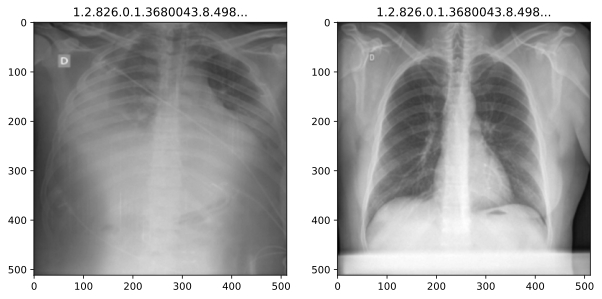

In [16]:
(fig, ax_vec) = plt.subplots(1, len(sample_patients_list), figsize = (10, 8))

for idx, cxr_fn in enumerate(sample_patients_list):

  cxr_path = os.path.join(test_set_dir, cxr_fn)
  cxr_img = plt.imread(cxr_path)
  ax_vec[idx].imshow(cxr_img, cmap = "gray")
  
  # if the CXRs are obtained from DICOM data, the names will likely be 50+ charachters long
  # to make it more easily human readable, trim the name!
  if len(cxr_fn) > 25:
      cxr_fn = cxr_fn[:25] + "..."
      
  ax_vec[idx].set_title(cxr_fn)

---

## Data Processing

The ensemble model was developed using roughly 150'000 Chest X-Ray (CXR) exams of more than 40'000 asymptomatic participants from the Prostate, Lung, Colorectal, and Ovarian cancer screening trial (PLCO) to predict lung-related mortality (COPD, interstitial lung disease, emphysema, lung cancer) based on a single CXR image as input.

The ensemble model is composed of 20 different models, based on different architectures and learning parameters. In particular, we conducted a grid search and trained several different models - eventually selecting four ResNet34, eleven InceptionV4, and five custom CNNs; every model was trained using a set of hyperparameters (e.g., a batch size between 16 and 256) and a set of augmentations (e.g., mixup and cutmix augmentations).

Here follows the complete list of models and the specific set of hyperparameters and augmentation used.


In [17]:
# FIXME: we could drop some of the columns - e.g., "Dataset" (not really useful/informative)
model_details_df[:20]

,Unnamed: 0,Model_Name,Dataset,Batch_Size,Epochs,Architecture,Target,LR,Bootstrap,Two_Phase,Data_Augs,Segmentation_Model,Image_Size,Train_Metric,Tune_Metric,MixUp,CutMix,Normalize,Num_Classes
0,0,Lung_Age_081221_0,/home/vraghu/Data/Aging/Computed_Lung_Age_Big_...,16,58,inceptionv4,computed_age_norm,0.003938972,1,0,1.794336,0,224,0.873723,0.883521,0,0,1,1
1,1,Lung_Age_081221_1,/home/vraghu/Data/Aging/Computed_Lung_Age_Big_...,32,41,inceptionv4,computed_age_norm,0.007298894956232847|0.0005545625388416647,1,1,1.602581,0,224,0.899656,0.864736,0,0,1,1
2,2,Lung_Age_081221_2,/home/vraghu/Data/Aging/Computed_Lung_Age_Big_...,64,56,inceptionv4,computed_age_norm,0.005474070424478631|0.00025038237282214084,1,1,1.098231,0,224,0.800858,0.839988,0,0,1,1
3,3,Lung_Age_081221_3,/home/vraghu/Data/Aging/Computed_Lung_Age_Big_...,128,50,tiny,computed_age_norm,0.006511004,1,0,1.091860,0,224,0.827872,0.853670,0,0,1,1
4,4,Lung_Age_081221_4,/home/vraghu/Data/Aging/Computed_Lung_Age_Big_...,32,56,tiny,computed_age_norm,0.005230311858331159|0.00022717141868696696,1,1,1.423842,0,224,0.758154,0.820246,1,0,1,1
5,5,Lung_Age_081221_5,/home/vraghu/Data/Aging/Computed_Lung_Age_Big_...,64,64,inceptionv4,computed_age_norm,0.00452247578023446|0.0002681868908344997,1,1,1.702723,0,224,0.815413,0.836397,1,0,1,1
6,6,Lung_Age_081221_6,/home/vraghu/Data/Aging/Computed_Lung_Age_Big_...,256,66,inceptionv4,computed_age_norm,0.001758994995687625|3.75312510762543e-05,1,1,1.405824,0,224,0.855401,0.870657,1,0,1,1
7,7,Lung_Age_081221_7,/home/vraghu/Data/Aging/Computed_Lung_Age_Big_...,32,53,resnet34,computed_age_norm,0.0013533371012198828|5.631373671283039e-05,1,1,1.444984,0,224,0.785826,0.819112,1,0,1,1
8,8,Lung_Age_081221_8,/home/vraghu/Data/Aging/Computed_Lung_Age_Big_...,16,40,inceptionv4,computed_age_norm,0.008946,1,0,1.565458,0,224,1.037992,1.343729,0,0,1,1
9,9,Lung_Age_081221_9,/home/vraghu/Data/Aging/Computed_Lung_Age_Big_...,16,55,resnet34,computed_age_norm,0.004423407556474674|0.0009212566429933129,1,1,1.177834,0,224,0.806815,0.833248,0,0,1,1


Additional details on the development process can be found in the publication.


We can finally move on to the code needed for the data processing.

In [18]:
%%capture
!pip install docopt
!pip install pretrainedmodels

In [19]:
import sys

import warnings
warnings.simplefilter(action = 'ignore')

import math
import time
import pretrainedmodels

import pandas as pd

from docopt import docopt
from sklearn.metrics import *

import torch
import torch.nn as nn
import torch.nn.functional as F

import src.SimpleArchs

import fastai
from fastai.vision.all import *

In [20]:
# if the instance is equipped with a GPU, set the relevant environment variable
# so that the GPU is used (only one GPU with ID "0" will be available)
if use_gpu:
  os.environ["CUDA_VISIBLE_DEVICES"] = "0"

---

The following cell will prepare the Pandas DataFrame `results_df` to be populated during the inference phase.

In [21]:
# The results of the inference phase are stored in the DataFrame "results_df"

# Dummy is a dummy nonsense variable to act as the fake "target variable" - necessary for the pipeline to run
# The column "valid_col" is True for all samples except for an artificial sample at the end
# (since for the fast.ai learner to work, there needs to be a "training set" included too)
output_df = pd.DataFrame(columns = ['File', 'Dummy', 'Prediction'])
output_df['File'] = patients_list
output_df['Dummy'] = np.random.random_sample(len(patients_list))
output_df['valid_col'] = np.repeat(True, output_df.shape[0])

# Add an additional image to act as the dummy training set, by setting the "valid_col" value to False
results_df = output_df.append(output_df.iloc[output_df.shape[0] -1, :],
                              ignore_index = True)

results_df.loc[results_df.shape[0] -1, 'valid_col'] = False   

We can check the weights computed using the LASSO regression for each model of the ensemble by inspecting the `ensemble_weights_df` DataFrame. These weights are provided as part of the repository in the `ensemble_weights.csv` file.

In [22]:
ensemble_weights_df

,Model_Name,weight
0,Lung_Age_081221_0,-1.155171
1,Lung_Age_081221_1,0.000000
2,Lung_Age_081221_2,2.003647
3,Lung_Age_081221_3,-1.672621
4,Lung_Age_081221_4,1.801023
5,Lung_Age_081221_5,-0.485328
6,Lung_Age_081221_6,0.000000
7,Lung_Age_081221_7,0.000000
8,Lung_Age_081221_8,0.000000
9,Lung_Age_081221_9,-0.216177


The next cell will run the inference loop for every model in the ensemble - by loading the model weights, the image, and running the processing.

Depending on the amount of data to be processed (and whether the Colab Instance is equipped with a GPU - as well as the type of GPU the instance is equipped with), this cell could take a very long time to run.

On a CPU instance, for the small sample of patients provided, this should take around one minute. On a GPU instance, processing times will be significantly reduced.

In [23]:
# The number of models in the ensemble corresponds to the number of rows in the "model_details_df" dataframe
# In this specific case, the number of models should be 20
model_number = model_details_df.shape[0]
mbar = master_bar(range(model_number))

print()

# Create an empty array of num_images x 20 (20-models-ensemble)
pred_arr = np.zeros((results_df.shape[0]-1, model_number))

# run the inference loop for every model in the ensemble
for model_id in mbar:
  out_nodes = int(model_details_df.Num_Classes[model_id])
  manual = False
  size = int(model_details_df.Image_Size[model_id])
  bs,val_bs = 4,4
  if(int(model_details_df.Normalize[model_id])==0):
    imgs = ImageDataLoaders.from_df(df = results_df, path = test_set_dir,
                                    label_col = "Dummy", y_block = RegressionBlock, bs = bs,
                                    val_bs = val_bs, valid_col = "valid_col",
                                    item_tfms = Resize(size), batch_tfms = None)
  else:
    imgs = ImageDataLoaders.from_df(df = results_df, path = test_set_dir,
                                    label_col = "Dummy", y_block = RegressionBlock, bs = bs,
                                    val_bs = val_bs, valid_col = "valid_col",
                                    item_tfms = Resize(size),
                                    batch_tfms = [Normalize.from_stats(*imagenet_stats)])

  # parse the model architecture from the "model_details_fn" file;
  # based on the model hyperparameters and details (stored in "model_hyperparams_df"),
  # initialise automatically a cnn learner object
  try:
    model_arch = model_details_df.Architecture[model_id].lower()
    
    # Cadene's pretrainedmodels InceptionV4 loading
    if(model_arch == "inceptionv4"):
      def get_model(pretrained = True, model_name = 'inceptionv4', **kwargs ): 
        if pretrained:
          arch = pretrainedmodels.__dict__[model_name](num_classes = 1000, pretrained = 'imagenet')
        else:
          arch = pretrainedmodels.__dict__[model_name](num_classes = 1000, pretrained = None)
        return arch

      def get_cadene_model(pretrained=True, **kwargs ): 
        return fastai_inceptionv4

      custom_head = create_head(nf = 2048*2, n_out = 37) 
      fastai_inceptionv4 = nn.Sequential(*list(get_model(model_name = 'inceptionv4').children())[:-2], custom_head) 
    
    elif(model_arch == "resnet34"):
      mdl = fastai.vision.models.resnet34
    
    elif(model_arch == "tiny"):
      manual = True
      mdl = src.SimpleArchs.get_simple_model("Tiny", out_nodes)

    else:
      print("Architecture type: " + model_arch + " not supported. " \
      "Please, make sure the `model_spec` CSV is found in the working directory and can be accessed.")
      quit()

    if(model_arch == 'inceptionv4'):
      learn = cnn_learner(imgs, get_cadene_model,n_out = out_nodes)

    elif(manual):
      learn = Learner(imgs,mdl)

    else:
      learn = cnn_learner(imgs, mdl, n_out = out_nodes)

  except:
    print("Architecture not found for model #: " + str(model_id))
    sys.exit(0)


  learn.path = Path(mdl_dir.split("models")[0])
  learn.load(mdl_name + "_" + str(model_id))
  
  # run the inference phase
  preds, y = learn.get_preds(ds_idx = 1, reorder = False)

  # store the raw model predictions for all the subject in `test_set_dir`
  pred_arr[:, model_id] = np.array(preds[:, 0])

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 133MB/s]


Finally, aggregate the predictions using the LASSO weights and intercept computed on the tuning set.

In [24]:
# parse the LASSO ensemble weights from the CSV file shared with the repository
ensemble_weights = ensemble_weights_df["weight"].values

# define the LASSO ensemble intercept computed on the tuning set
lasso_intercept = 49.8484258

# compute the final CXR-Lung-Risk by ensembling the scores
predictions = np.matmul(pred_arr, ensemble_weights) + lasso_intercept

output_df['CXR_Lung_Risk'] = predictions
output_df = output_df.drop(["valid_col", "Dummy", "Prediction"], axis = 1)

---

The output of the pipeline is a Pandas DataFrame storing the name of each processed file and the CXR-Lung-Risk score.

In [25]:
output_df

,File,CXR_Lung_Risk
0,1.2.826.0.1.3680043.8.498.32891312658070649342335208084432672152-c.png,58.361936
1,1.2.826.0.1.3680043.8.498.12414243101975237693704262413365291546-c.png,40.386440
2,1.2.826.0.1.3680043.8.498.29960944389705651248668522443366935719-c.png,52.515098
3,1.2.826.0.1.3680043.8.498.23886477039785083148480341399342435216-c.png,45.186783
4,1.2.826.0.1.3680043.8.498.12764119488911678486346710898310965684-c.png,48.215590


The DataFrame can be converted into a CSV file and downloaded locally for further analyses.

In [26]:
output_df.to_csv(out_file_path, index = False)

# consider zipping the CSV file if the number of patients processed is very large!
files.download(out_file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>